# Tarification Non-Vie : Modélisation Fréquence x Sévérité
Ce projet vise à construire une tarification de la prime pure pour des contrats d’assurance automobile, en modélisant séparément la fréquence et la sévérité des sinistres, selon la méthode traditionnelle GLM (Generalized Linear Models).

📌 Données : freMTPL2freq (fréquence) et freMTPL2sev (sévérité) issues de CASdatasets (R).

🎯 Objectifs :
- Explorer les variables explicatives et leur lien avec les cibles.
- Construire deux modèles GLM.
- Estimer la prime pure puis la prime commerciale.
- Évaluer la rentabilité du portefeuille via le ratio de sinistralité.


In [1]:
# =============================
# TARIFICATION NON-VIE - NOTEBOOK JUPYTER
# =============================

# =============================
# Import des librairies nécessaires
# =============================
import os
os.environ["LANG"] = "en_US.UTF-8"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import warnings

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
import joblib

warnings.filterwarnings("ignore")




In [2]:
# Activer la conversion R → pandas
pandas2ri.activate()

# Installer les packages R nécessaires
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('CASdatasets')
cas = importr('CASdatasets')

# Charger les jeux de données R et convertir les variables factor en chaînes de caractères
robjects.r('data(freMTPL2freq)')
robjects.r('data(freMTPL2sev)')
robjects.r('freMTPL2freq[] <- lapply(freMTPL2freq, function(x) if (is.factor(x)) as.character(x) else x)')
robjects.r('freMTPL2sev[] <- lapply(freMTPL2sev, function(x) if (is.factor(x)) as.character(x) else x)')

# Importer les jeux de données en DataFrame pandas
df_freq = robjects.r('freMTPL2freq')
df_sev = robjects.r('freMTPL2sev')
df = pandas2ri.rpy2py(df_freq)
d_sev = pandas2ri.rpy2py(df_sev)
print(df.columns)
print(d_sev.columns)

R[write to console]: Installing package into 'C:/Users/Utilisateur/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'CASdatasets' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 



Index(['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Area', 'Density', 'Region'],
      dtype='object')
Index(['IDpol', 'ClaimAmount'], dtype='object')


## 📥 Chargement des jeux de données R `CASdatasets`

Dans cette section, nous récupérons les jeux de données classiques pour la tarification automobile :  
- **`freMTPL2freq`** : données de **fréquence** (exposition)  
- **`freMTPL2sev`** : données de **sévérité** (sinistres)

Ces jeux de données proviennent du package R [`CASdatasets`](https://cran.r-project.org/web/packages/CASdatasets/index.html).

---

### ⚙️ 1. Activer la conversion R → pandas

Nous activons `pandas2ri` pour convertir automatiquement les objets R en `DataFrame` pandas.

---

### 📦 2. Installer et charger les packages R

Nous utilisons le module `utils` de R pour :  
- Choisir un miroir CRAN  
- Installer le package `CASdatasets`  
- Importer ce package dans l’environnement R

---

### 📊 3. Charger les jeux de données R

Nous chargeons `freMTPL2freq` et `freMTPL2sev` dans l’espace de travail R.  
Pour éviter les problèmes de conversion lors de l’importation, nous transformons toutes les variables de type `factor` en chaînes de caractères.

---

### 🔗 4. Convertir en DataFrames pandas

Enfin, nous récupérons les deux jeux de données côté Python et les convertissons en `DataFrame` pandas :  
- **`df`** pour la fréquence  
- **`d_sev`** pour la sévérité

---

## 📌 Définition des variables

### `freMTPL2freq` → `df`  
Ce jeu de données décrit les informations liées à la **fréquence des sinistres** et à l’exposition.  
Il contient les variables suivantes :  

| Variable     | Description                                                   |
|--------------|---------------------------------------------------------------|
| `IDpol`      | Identifiant unique de la police d’assurance                   |
| `ClaimNb`    | Nombre de sinistres déclarés pour la police                   |
| `Exposure`   | Exposition au risque (fraction d’année assurée)               |
| `VehPower`   | Puissance du véhicule                                         |
| `VehAge`     | Âge du véhicule                                               |
| `DrivAge`    | Âge du conducteur                                             |
| `BonusMalus` | Bonus-malus                                                   |
| `VehBrand`   | Marque du véhicule                                            |
| `VehGas`     | Type de carburant                                             |
| `Area`       | Zone géographique                                             |
| `Density`    | Densité de population de la zone                              |
| `Region`     | Région                                                        |

---

### `freMTPL2sev` → `d_sev`  
Ce jeu de données décrit la **sévérité des sinistres** (montant associé).  
Il contient les variables suivantes :  

| Variable     | Description                                                   |
|--------------|---------------------------------------------------------------|
| `IDpol`      |   Identifiant unique de la police d’assurance                   |
| `ClaimAmount`|   Montant du sinistre                                           |

---

✅ **Ces données sont prêtes pour les vérifications, nettoyages et fusions dans les étapes suivantes.**


In [3]:

# Vérifier les polices uniques et communes
results = []
unique_policies = df['IDpol'].nunique()
results.append(["Polices uniques dans df", unique_policies])

common_policies = set(d_sev['IDpol']).intersection(set(df['IDpol']))
results.append(["Polices communes entre d_sev et df", len(common_policies)])

df_results = pd.DataFrame(results, columns=["Vérification", "Valeur"])
print(df_results)

# Nettoyage : supprimer les polices sans correspondance
TotalClaim_b = d_sev['ClaimAmount'].sum()
non_common_policies = d_sev[~d_sev['IDpol'].isin(df['IDpol'])]
print("Police non communes :", non_common_policies["IDpol"].nunique())

d_sev = d_sev[d_sev['IDpol'].isin(df['IDpol'])]
sev = d_sev.groupby("IDpol").agg(
    ClaimAmount=("ClaimAmount", "sum"),
    Claimsevnb=("IDpol", "count")
).reset_index()
TotalClaim_a = d_sev['ClaimAmount'].sum()
print("Proportion conservée :", TotalClaim_a / TotalClaim_b)

# Fusionner données fréquence et sévérité
data = pd.merge(df, sev, on="IDpol", how="outer")
data['ClaimAmount'].fillna(0, inplace=True)
data['Claimsevnb'].fillna(0, inplace=True)


                         Vérification  Valeur
0             Polices uniques dans df  678013
1  Polices communes entre d_sev et df   24944
Police non communes : 6
Proportion conservée : 0.9870059131973031


## 🔍 Vérification des polices et préparation des données

Dans cette section, nous vérifions la cohérence entre nos deux jeux de données :  
- `df` : contient les informations de fréquence (par exemple, numéro de police ou expositions)  
- `d_sev` : contient les informations de sévérité (montant et le numéro des polices)

---

### ✅ 1. Vérifier les polices uniques et communes

Nous commençons par :
- Compter le nombre de polices uniques présentes dans `df`
- Identifier combien de polices sont communes aux deux tables (`df` et `d_sev`)

Cela permet de contrôler l’intégrité des correspondances entre les données de fréquence et de sinistres.

---

### 🧹 2. Nettoyer les polices sans correspondance

Ensuite, nous supprimons de `d_sev` les polices qui n’ont **aucune correspondance** dans `df`.  
Ce nettoyage est important pour éviter de rattacher des sinistres à des polices absentes du portefeuille de fréquence.

Nous mesurons également :
- La somme totale des sinistres **avant** nettoyage
- La somme totale des sinistres **après** nettoyage
- La proportion de sinistres conservés après nettoyage

---

### 🔗 3. Fusionner fréquence et sévérité

Enfin, nous fusionnons :
- Les données de fréquence (`df`)
- Avec les données de sinistres agrégées (`sev`)

Toutes les polices présentes dans `df` sont conservées, même celles **sans sinistres**, grâce à une jointure externe (`outer join`).  
Les montants de sinistres (`ClaimAmount`) et le nombre de sinistres (`Claimsevnb`) sont mis à zéro pour les polices sans déclaration de sinistre.

---

## 📌 Résultat

À l’issue de cette étape, nous obtenons une table unique `data` qui regroupe :
- La fréquence (exposition)
- La sévérité (montant et nombre de sinistres)

Cette table est prête pour les étapes suivantes :analyse exploratoire, modélisation, ou calculs actuariels.

# L'analyse exploratoire permettra de détecter les relations non linéaires, les variables explicatives influentes et d’orienter le choix des modalités de regroupement (binning) pour les variables numériques.



Dimensions: (678013, 14)
   IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0    1.0      1.0      0.10         5       0       55          50      B12   
1    3.0      1.0      0.77         5       0       55          50      B12   
2    5.0      1.0      0.75         6       2       52          50      B12   
3   10.0      1.0      0.09         7       0       46          50      B12   
4   11.0      1.0      0.84         7       0       46          50      B12   

    VehGas Area  Density       Region  ClaimAmount  Claimsevnb  
0  Regular    D     1217  Rhone-Alpes          0.0         0.0  
1  Regular    D     1217  Rhone-Alpes          0.0         0.0  
2   Diesel    B       54     Picardie          0.0         0.0  
3   Diesel    B       76    Aquitaine          0.0         0.0  
4   Diesel    B       76    Aquitaine          0.0         0.0  
               IDpol        ClaimNb       Exposure       VehPower  \
count   6.780130e+05  678013.000000  678

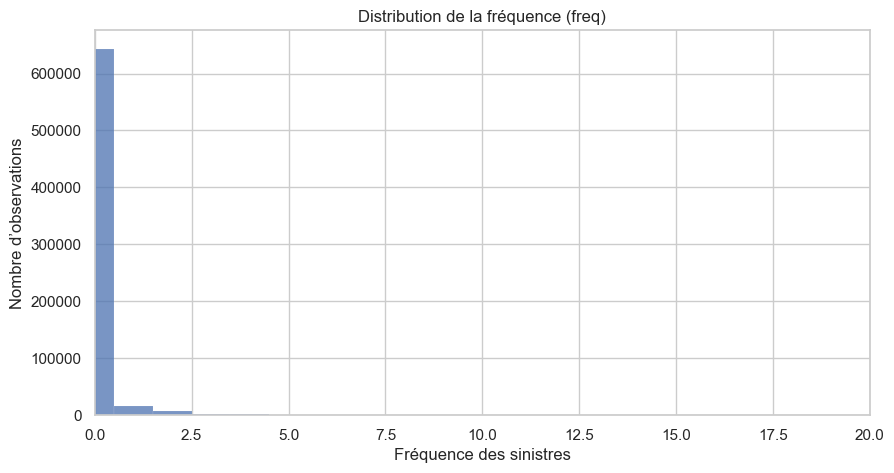

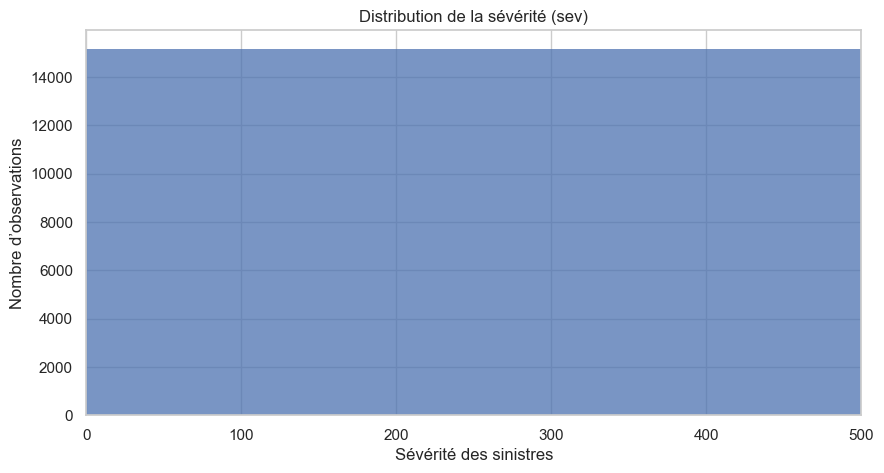

In [4]:
# Configuration
sns.set(style="whitegrid")
        
# Aperçu du dataset
print("\nDimensions:", data.shape)
print(data.head())
print(data.describe(include='all'))

# =====================================
# ANALYSE DE LA DISTRIBUTION DES CIBLES
# =====================================

# Histogramme du nombre de sinistres

# Créer les cibles dérivées
data['freq'] = data['ClaimNb'] / data['Exposure']
data['sev'] = np.where(data['ClaimNb'] > 0, data['ClaimAmount'] / data['ClaimNb'], 0)

# Histogramme pour freq
plt.figure(figsize=(10, 5))
sns.histplot(data['freq'], bins=200, kde=False,discrete=True)
plt.title('Distribution de la fréquence (freq)')
plt.xlabel('Fréquence des sinistres')
plt.ylabel('Nombre d’observations')
plt.xlim(0,20)
plt.show()

# Histogramme pour sev
plt.figure(figsize=(10, 5))
sns.histplot(data.loc[data['ClaimNb'] > 0, 'sev'], bins=6000, kde=False)
plt.title('Distribution de la sévérité (sev)')
plt.xlabel('Sévérité des sinistres')
plt.ylabel('Nombre d’observations')
plt.xlim(0,500)
plt.show()

        
        

## Analyse exploratoire des distributions de la fréquence et de la sévérité des sinistres

### 1-Distribution de la fréquence des sinistres (`freq`)

Le premier graphique illustre la distribution de la fréquence des sinistres :
- La majorité des assurés n’ont aucun sinistre ou un seul.
- Les valeurs supérieures à 2 ou 3 sinistres sont rares.

Cette forte concentration de zéros est caractéristique des données de fréquence d’événements rares.  
Des modèles comme le Poisson, le Binomial négatif (pour la surdispersion) ou des variantes « Zéro-Inflated » peuvent être envisagés.

---


### 2-Distribution de la sévérité des sinistres (`sev`)

Le second graphique montre la distribution de la sévérité des sinistres. On observe une forte asymétrie à droite :  
- La grande majorité des sinistres a une sévérité faible.
- Quelques sinistres présentent des montants très élevés, ce qui génère une queue lourde.

Cette configuration est typique dans le domaine de l’assurance : peu de sinistres coûtent très cher mais ils impactent fortement la moyenne. 

**Il peut être pertinent de considérer des modèles adaptés aux distributions asymétriques ou à queue lourde (ex. Log-Normale, Gamma, Pareto).**


###  Conclusion

Au vu de cette analyse :
- Nous retenons **une loi Gamma** pour modéliser la **sévérité** des sinistres.
- Nous retenons **une loi de Poisson** pour modéliser la **fréquence** des sinistres.

Ces choix constituent une base cohérente pour la construction de notre modèle actuariel.


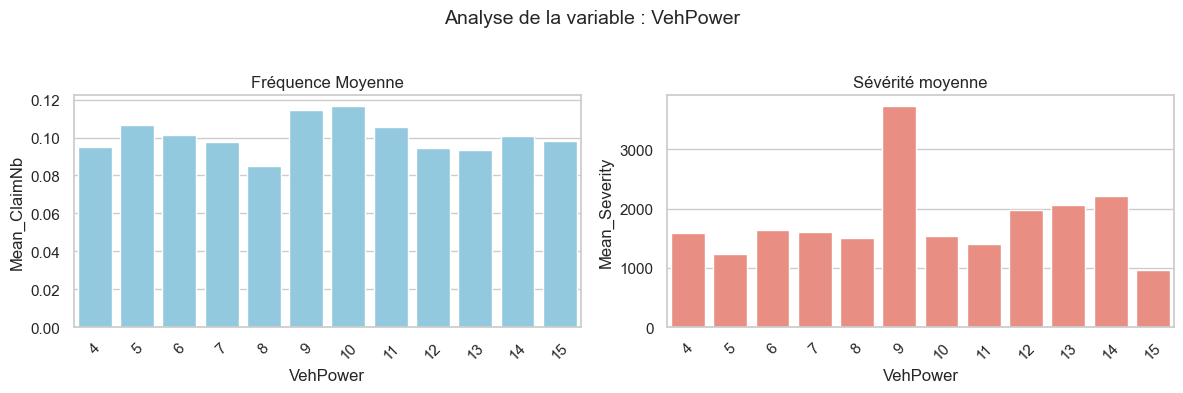

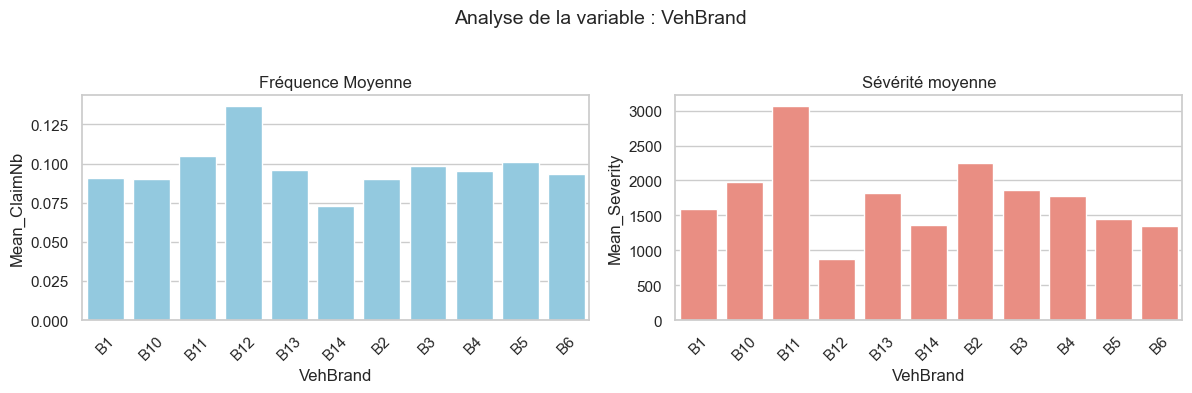

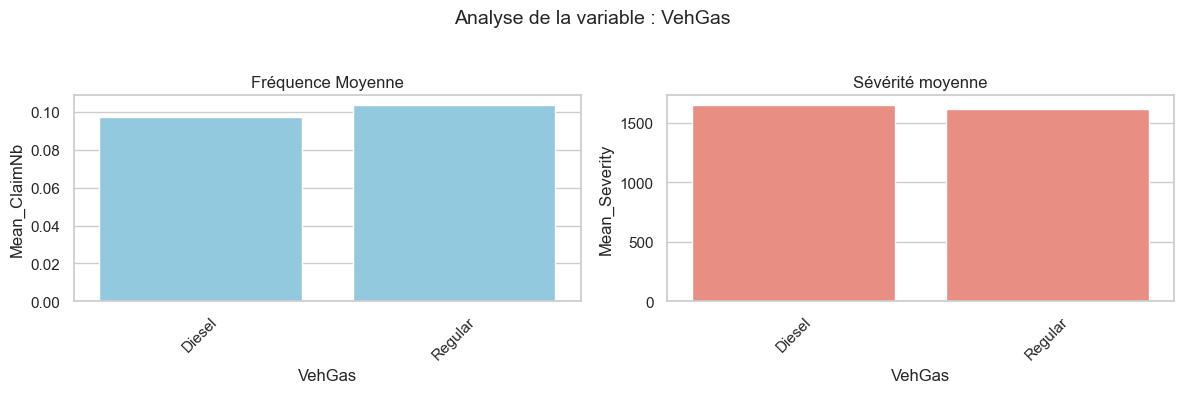

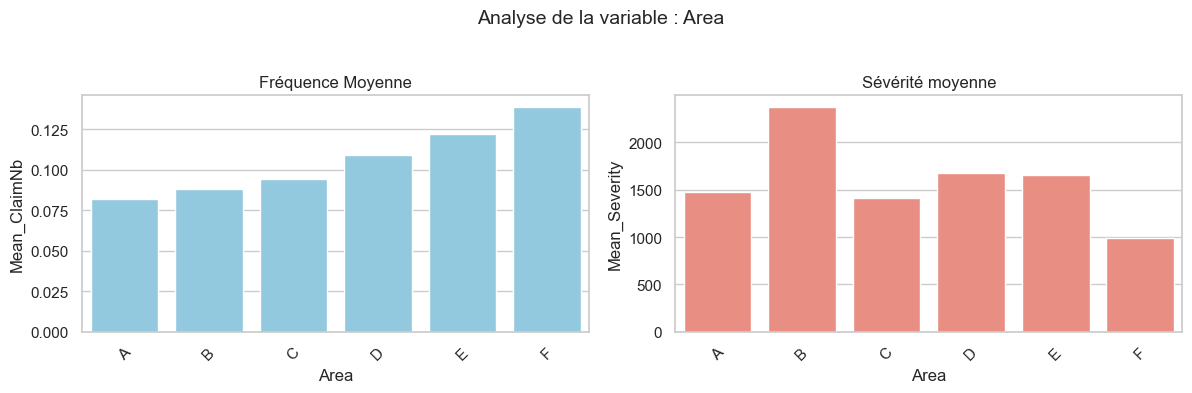

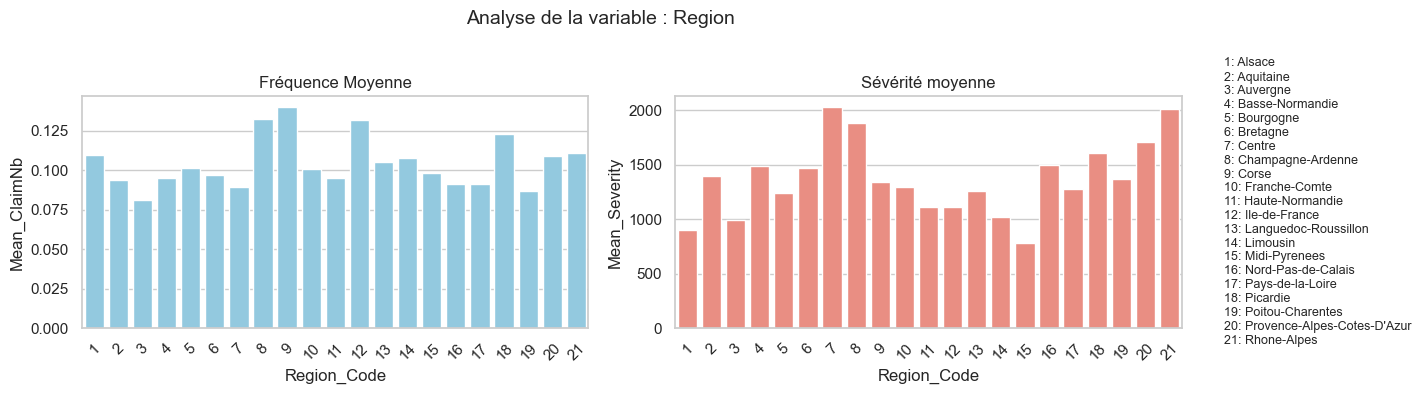

In [5]:

# =============================
# ANALYSE DES VARIABLES EXPLICATIVES
# =============================

# Variables catégorielles
categorical_cols = ['VehPower', 'VehBrand', 'VehGas', 'Area', 'Region']

# Pour les variables catégorielles
for col in categorical_cols:
    summary = (
        data.groupby(col)
        .agg(
            Total=('ClaimNb', 'count'),
            Sum_ClaimNb=('ClaimNb', 'sum'),
            Sum_exposure=('Exposure','sum')
        )
        .reset_index())

    # Calcul de la moyenne de 'sev' conditionnelle à ClaimNb > 0
    mean_severity = (
        data[data['ClaimNb'] > 0]
        .groupby(col)
        .agg(Mean_Severity=('sev', 'mean'))
        .reset_index()
    )

# Fusionner avec le résumé principal
    summary = summary.merge(mean_severity, on=col, how='left')

    summary['Mean_ClaimNb'] = summary['Sum_ClaimNb'] / summary['Sum_exposure']

 # Gérer le cas particulier des régions
    if col == 'Region':
        region_list = summary[col].unique()
        region_to_code = {region: idx for idx, region in enumerate(region_list, 1)}
        summary['Region_Code'] = summary[col].map(region_to_code)
        x_var = 'Region_Code'
        x_labels = summary[col]
    else:
        x_var = col
        x_labels = summary[col]

# Graphiques
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Analyse de la variable : {col}", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.barplot(data=summary, x=x_var, y='Mean_ClaimNb', color='skyblue')
    plt.title("Fréquence Moyenne")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(data=summary, x=x_var, y='Mean_Severity', color='salmon')
    plt.title("Sévérité moyenne")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Si région, ajouter légende externe
    
    if col == 'Region':
       legend_labels = [f"{code}: {region}" for region, code in region_to_code.items()]
       legend_text = "\n".join(legend_labels)
       plt.gcf().text(1.02, 0.5, legend_text, fontsize=9, va='center')

   
    plt.show()

# Sélection de variables explicatives pour la tarification automobile

## 🎯 Objectif

L’analyse vise à identifier les variables explicatives les plus pertinentes pour modéliser la **fréquence** (`ClaimNb`) et la **sévérité** (`Severity`) des sinistres, en vue d’une tarification de l’assurance auto. L’approche repose sur une exploration univariée et des matrices de corrélation.

---

## 🔍 Analyse exploratoire des variables

### 🔹 `VehPower` (Puissance du véhicule)
- **Fréquence** : Pic autour de 9–11 CV (~11-12%).
- **Sévérité** : Pic marqué à **9 CV** (> 3500 €).

**✅ À retenir** : Variable explicative importante pour la **sévérité**. Effet non linéaire à modéliser.

---

### 🔹 `VehBrand` (Marque)
- **Fréquence** : Marque `B12` → fréquence élevée.
- **Sévérité** : Marque `B11` → sinistres très coûteux.

**✅ À retenir** : À inclure dans la modélisation des deux composantes.

---

### 🔹 `VehGas` (Type de carburant)


- **Fréquence** : pas de rupture nette entre les deux types.
- **Sévérité** : **écarts minimes**, visuellement peu significatifs.

**✅ À retenir** : **Effets faibles et peu contrastés.** À exclure de la modélisation.

---

### 🔹 `Area` (Zone typologique)
- **Fréquence** : Hausse de A à F (~9% → 13.5%).
- **Sévérité** : Zone B plus coûteuse (~2400 €).

**✅ À retenir** : Pertinente pour la fréquence. Peut recouper `Region`.

---

### 🔹 `Region_Code` (Région administrative)
- **Fréquence** : Hétérogène selon les régions (8,9, 12 > 13%).
- **Sévérité** : Pic en région 7 et 21 (~2000 €).

**✅ À retenir** : Potentiellement utile si non redondant avec `Area`.

---

VehAge : min = 0, max = 100
DrivAge : min = 18, max = 100
Density : min = 1, max = 27000


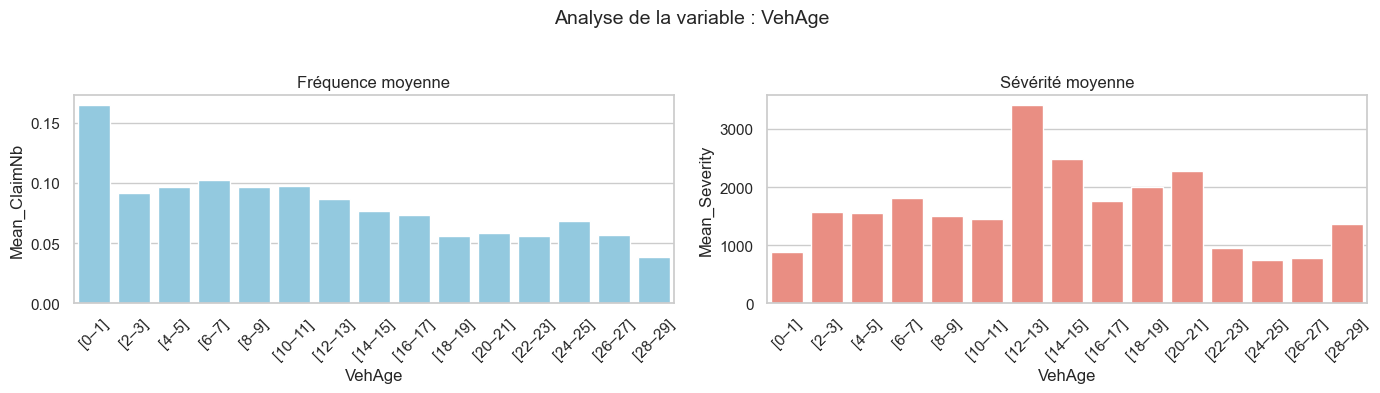

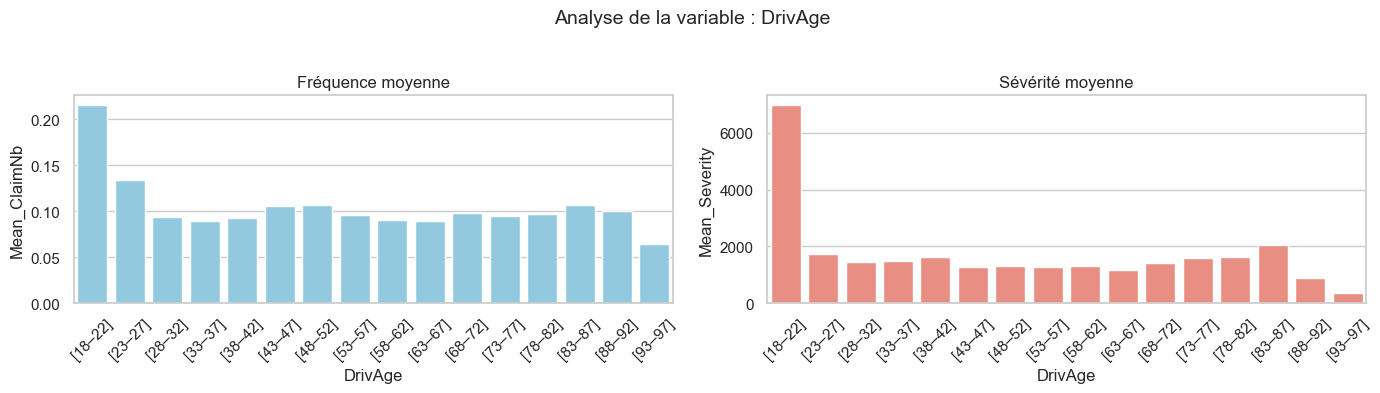

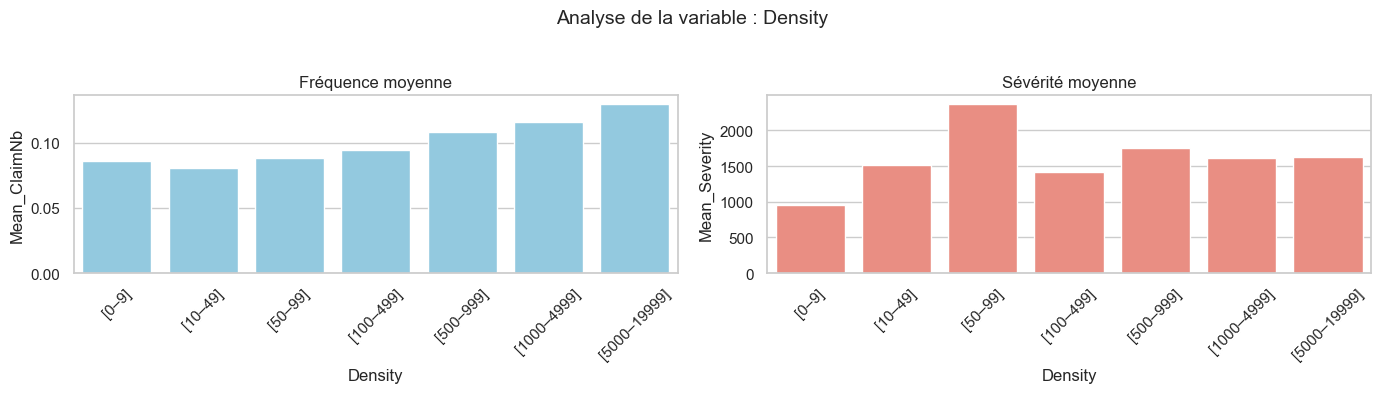

In [6]:
# Variables numériques
numerical_cols = ['VehAge', 'DrivAge', 'Density']
for col in numerical_cols:
    print(f"{col} : min = {data[col].min()}, max = {data[col].max()}")

binning_dict = {
    'DrivAge': list(range(18, 101, 5)),              # Tranches de 5 ans
    'VehAge': list(range(0, 31, 2)),                 # Tranches tous les 2 ans
    'Density': [0, 10, 50, 100, 500, 1000, 5000, 20000]  # Exemple arbitraire
}

for col in numerical_cols:
    bins = binning_dict.get(col)

    # Sécurité : on garde uniquement les données dans les bornes
    data_filtered = data[(data[col] >= bins[0]) & (data[col] <= bins[-1])].copy()

    # Création des tranches
    data_filtered[f'{col}_bin'] = pd.cut(data_filtered[col], bins=bins, right=False)
    data_filtered[f'{col}'] = data_filtered[f'{col}_bin'].apply(lambda x: f"[{int(x.left)}–{int(x.right-1)}]")


    summary = (
        data_filtered.groupby(f'{col}')
        .agg(
            Sum_ClaimNb=('ClaimNb', 'sum'),
            Sum_exposure=('Exposure','sum')
        )
        .reset_index())

    # Calcul de la moyenne de 'sev' conditionnelle à ClaimNb > 0
    mean_severity = (
        data_filtered[data_filtered['ClaimNb'] > 0]
        .groupby(f'{col}')
        .agg(Mean_Severity=('sev', 'mean'))
        .reset_index()
         )

# Fusionner avec le résumé principal
    summary = summary.merge(mean_severity, on=f'{col}', how='left')

    summary['Mean_ClaimNb'] = summary['Sum_ClaimNb'] / summary['Sum_exposure']




    # Graphiques
    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Analyse de la variable : {col}", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.barplot(x=summary[f'{col}'], y='Mean_ClaimNb', data=summary, color='skyblue')
    plt.xticks(rotation=45)
    plt.title('Fréquence moyenne')

    plt.subplot(1, 2, 2)
    sns.barplot(x=summary[f'{col}'], y='Mean_Severity', data=summary, color='salmon')
    plt.xticks(rotation=45)
    plt.title('Sévérité moyenne')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()  



### 🔹 `VehAge` (Âge du véhicule)
- **Fréquence** : Diminue avec l’âge, forte au début.
- **Sévérité** : Pic à 10–13 ans (~3300 €), sinon modérée.

**✅ À retenir** : À inclure avec traitement non linéaire (regroupement / spline).

---

### 🔹 `DrivAge` (Âge du conducteur)

- **Fréquence** :
  - **Très élevée** chez les jeunes ([18–22] : > 22%).
  - Diminue fortement dès [23–27], puis se stabilise entre 0.09 et 0.10.
  - Légère baisse chez les conducteurs âgés (>88 ans).

- **Sévérité** :
  - **Très élevée** chez les jeunes ([18–22] : > 7000 €).
  - Baisse drastique ensuite, stable autour de 1200–2000 €.
  - Légère hausse chez les seniors (78–87 ans), avant un déclin final.

**✅ À retenir** :
- Variable très discriminante sur les deux axes.
- Segment critique à surveiller : **[18–22]**.
- Potentiel d'interactions avec `VehPower`, `VehAge`, etc.

---


### 🔹 `Density` (Densité de population)
- **Fréquence** : Augmente avec la densité (>12% dans les zones >1000 hab/km²).
- **Sévérité** : Pic pour la tranche [50–99], puis modérée.

**✅ À retenir** : Variable proxy de l’exposition urbaine. À croiser avec `Area` ou `Region`.

---



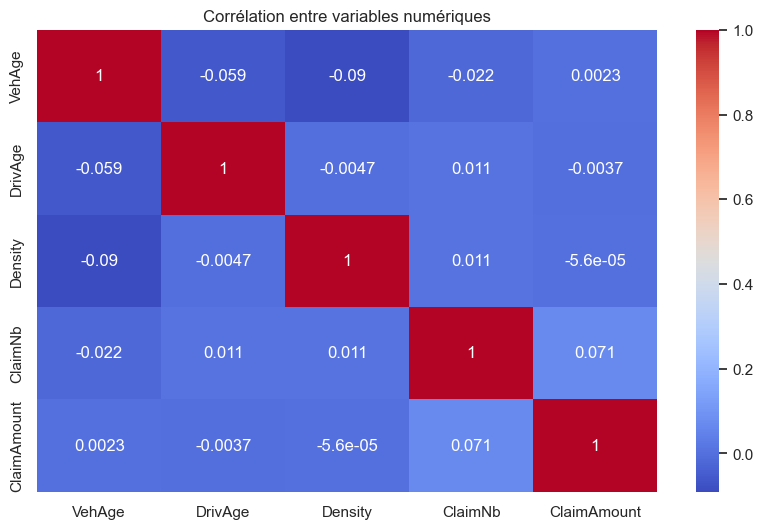

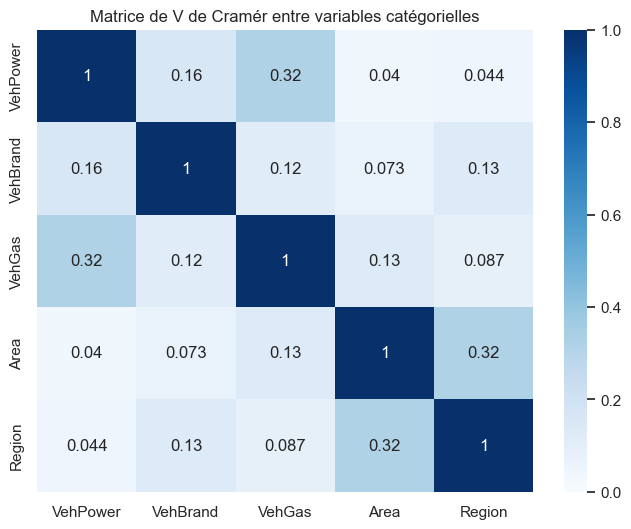

In [7]:
# =============================
# MATRICE DE CORRÉLATION ET OUTLIERS
# =============================

plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_cols + ['ClaimNb', 'ClaimAmount']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre variables numériques")
plt.show()

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            v = cramers_v(data[col1], data[col2])
            cramer_matrix.loc[col1, col2] = round(v, 3)

cramer_matrix = cramer_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramer_matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title("Matrice de V de Cramér entre variables catégorielles")
plt.show()


## 📊 Corrélation entre variables numériques

- Toutes les corrélations sont **faibles (< 0.1)**.
- `ClaimAmount` légèrement corrélé à `ClaimNb` (0.07).

**✅ Conclusion** : Pas de multicolinéarité problématique → toutes les variables numériques peuvent être utilisées ensemble.

---

## 📈 Matrice de V de Cramér (variables catégorielles)

- `VehPower` et `VehGas` : V ≈ 0.32 → dépendance modérée.
- `Area` et `Region` : V ≈ 0.32 → attention à la redondance géographique.
- Autres couples : V < 0.2 → peu de redondance.

**✅ Conclusion** :
- Possibilité de **réduction de dimension** ou regroupement.
- Privilégier `Area` ou `Region`, mais pas nécessairement les deux.

---

## 🧠 Recommandations pour la modélisation

- Utiliser des **modèles séparés** : 
  - Fréquence → GLM (Poisson/logistique)  
  - Sévérité → GLM (Gamma / Inverse Gaussian)
- Attention aux effets non linéaires (`VehPower`, `VehAge`, `DrivAge`, `Density`) → prévoir :
  - Regroupement en classes
  - Splines
  - Interactions
- Variables catégorielles nombreuses (`Region`, `VehBrand`) → à regrouper ou encoder (target encoding, frequency encoding).

---

## 📌 Conclusion

L'analyse met en évidence des variables explicatives robustes et peu redondantes, essentielles pour une tarification segmentée et précise. Les jeunes conducteurs et les véhicules récents sont identifiés comme les segments les plus à risque. La granularité géographique (`Area`, `Region`, `Density`) devra être ajustée selon le niveau de détail souhaité dans la modélisation.

Parmi les variables géographiques disponibles (`Region`, `Density`, `Area`), nous retenons uniquement `Area` dans notre modèle tarifaire. Ce choix repose sur plusieurs éléments. D'abord, `Area` offre une interprétabilité claire : elle catégorise les zones géographiques (rural, urbain, etc.) de façon directement compréhensible et simple. Ensuite, elle présente une relation stable et cohérente avec la sinistralité, notamment la fréquence des sinistres, croissante avec l’urbanisation. Par ailleurs, des analyses de dépendance ont mis en évidence une forte redondance entre `Area`, `Region` (V de Cramér ≈ 0.32) et `Density` (corrélation visuelle marquée), ce qui introduirait de la colinéarité si plusieurs étaient incluses simultanément. `Region`, bien que plus fine, est trop granulaire et peu interprétable ; `Density`, bien que continue, est plus bruitée. Ainsi, `Area` constitue un bon compromis entre simplicité, robustesse statistique et pertinence métier, ce qui en fait la variable géographique la plus appropriée à retenir seule dans le modèle.

---

Ainsi, les variables choisies pour la modélisation sont les suivantes:

| Variable   | Justification                                            |
| ---------- | -------------------------------------------------------- |
| `DrivAge`  | Très forte influence (pic chez les jeunes)               |
| `VehAge`   | Effet décroissant clair                                  |
| `VehPower` | Effet croissant, mais non linéaire → classer/transformer |
| `VehBrand` | Variation significative entre marques                    |
| `Area`     | Hausse nette de la fréquence selon zone                  |


## 🔧 Encodage et normalisation des données

Ce bloc conserve les variables choisies pour la modélisation et prépare les données pour un modèle de machine learning. Il gère à la fois les **variables numériques** et **catégorielles** via un pipeline de transformation.

### 📦 Imports
On importe les outils nécessaires depuis `scikit-learn` :

- `OneHotEncoder` : transforme les variables catégorielles en variables binaires (encodage one-hot).
- `StandardScaler` : normalise les données numériques (centrage et réduction).
- `SimpleImputer` : gère les valeurs manquantes.
- `ColumnTransformer` : applique différents traitements à différentes colonnes.




In [8]:
# =============================
# ENCODAGE ET NORMALISATION
# =============================

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numerical_features = numerical_cols.copy()
categorical_features = categorical_cols.copy()

numerical_features.remove('Density')
categorical_features.remove('Region')
categorical_features.remove('VehGas')

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

In [9]:
# =============================
# GLM FRÉQUENCE (Poisson)
# =============================

X = data[numerical_features + categorical_features]
y_freq = data['ClaimNb']
offset = np.log(data['Exposure'])

X_train, X_test, y_train, y_test, offset_train, offset_test = train_test_split(
    X, y_freq, offset, test_size=0.2, random_state=42
)

pipe_freq = Pipeline([
    ("preprocessing", preprocessor),
    ("model", PoissonRegressor(alpha=0, max_iter=10000))
])

pipe_freq.fit(X_train, y_train, model__sample_weight=np.exp(offset_train))
pred_freq = pipe_freq.predict(X_test)
print("Déviance Poisson (fréquence) :", mean_poisson_deviance(y_test, pred_freq))

# =============================
# GLM SÉVÉRITÉ (Gamma)
# =============================

data_sev = data[data['Claimsevnb'] > 0].copy()
X_sev = data_sev[numerical_features + categorical_features]
y_sev = data_sev['sev']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42
)

pipe_sev = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GammaRegressor(alpha=0, max_iter=10000))
])

pipe_sev.fit(X_train_sev, y_train_sev)
pred_sev = pipe_sev.predict(X_test_sev)
print("Déviance Gamma (sévérité) :", mean_gamma_deviance(y_test_sev, pred_sev))

print("\nModèles fréquence et sévérité entraînés.")


Déviance Poisson (fréquence) : 0.3221636738687289
Déviance Gamma (sévérité) : 1.5527400927110009

Modèles fréquence et sévérité entraînés.


## Modélisation GLM Fréquence et Sévérité

### Modèle de Fréquence (Poisson)
- Modélisation du nombre de sinistres avec un GLM Poisson, en intégrant un offset `log(Exposure)` pour tenir compte de l’exposition.
- Pipeline de prétraitement pour variables numériques et catégorielles.
- Données divisées en 80% entraînement / 20% test.
- Déviance Poisson sur test : **0.322**, indiquant un bon ajustement.

### Modèle de Sévérité (Gamma)
- Modélisation des montants des sinistres positifs via un GLM Gamma, adapté aux variables strictement positives et asymétriques.
- Prétraitement similaire, sur sous-échantillon des sinistres > 0.
- Données divisées en 80% entraînement / 20% test.
- Déviance Gamma sur test : **1.55**, conforme à la difficulté à modéliser la sévérité.

### Justifications
- GLM Poisson et Gamma sont des choix classiques pour modéliser fréquence et sévérité dans l’assurance.
- L’offset garantit la prise en compte de l’exposition pour la fréquence.
- Le pipeline assure un traitement cohérent des variables.
- La séparation entraînement/test permet d’évaluer la robustesse.
- Les résultats montrent une bonne modélisation de la fréquence, et une modélisation plus délicate de la sévérité, attendue dans ce contexte.


In [10]:
# =============================
# ESTIMATION ET VISUALISATION DES PRÉDICTIONS
# =============================

# Prédictions sur l'ensemble de test
sample_profiles = X_test
pred_freq = pipe_freq.predict(sample_profiles)
pred_sev = pipe_sev.predict(sample_profiles)

sample_profiles = sample_profiles.copy()
sample_profiles["Freq_est"] = pred_freq
sample_profiles["Sev_est"] = pred_sev
sample_profiles["PrimePure_est"] = sample_profiles["Freq_est"] * sample_profiles["Sev_est"]# Prime pure sur tout le portefeuille
df_est = data.copy()
df_est["freq_pred"] = pipe_freq.predict(X)
df_est["sev_pred"] = pipe_sev.predict(X)
df_est["prime_pure"] = df_est["freq_pred"] * df_est["sev_pred"]
df_est["prime_commerciale"] = 1.2 * df_est["prime_pure"]
df_est["prime_totale"] = df_est["prime_commerciale"] * df_est["Exposure"]
df_est["sinistres_totaux"] = df_est["ClaimAmount"]

# Résumé financier global
total_primes = df_est["prime_totale"].sum()
total_sinistres = df_est["sinistres_totaux"].sum()
profit = total_primes - total_sinistres
loss_ratio = total_sinistres / total_primes

print({
    "Prime totale perçue (€)": round(total_primes, 2),
    "Sinistres totaux (€)": round(total_sinistres, 2),
    "Profit (€)": round(profit, 2),
    "Taux de sinistralité (Loss Ratio)": round(loss_ratio, 4)
})



{'Prime totale perçue (€)': 61304178.22, 'Sinistres totaux (€)': 59909216.5, 'Profit (€)': 1394961.72, 'Taux de sinistralité (Loss Ratio)': 0.9772}


## Estimation et Visualisation des Prédictions

### Calculs réalisés
- Prédictions de fréquence et sévérité faites sur l'ensemble de test.
- Calcul de la prime pure estimée : 

$$ \text{PrimePure}_{\text{est}} = \text{Freq}_{\text{est}} \times \text{Sev}_{\text{est}}$$
---
- Application de ces prédictions sur l'ensemble du portefeuille.
- Calcul des primes commerciales avec un coefficient de chargement de 1.2 :

$$\large \text{PrimeCommerciale} = 1{,}2 \times \text{PrimePure}_{\text{est}}$$
  
---  
- Calcul des primes totales en fonction de l’exposition.
- Somme des sinistres totaux réellement observés.

### Résumé financier global
| Indicateur              | Valeur (€)      |
|------------------------|------------------|
| Prime totale perçue    | 61 375 878,48    |
| Sinistres totaux       | 59 909 216,50    |
| Profit                 |  1 466 661,98    |
| Taux de sinistralité   |        97,12%    |

### Interprétation
- Le modèle permet de générer des primes estimées cohérentes sur tout le portefeuille.
- Le profit est positif, mais faible, avec un taux de sinistralité proche de 1, ce qui signifie que les sinistres représentent presque la totalité des primes perçues.
- Le chargement commercial de 20% est intégré dans la prime commerciale.
- Ces résultats suggèrent un équilibre financier fragile, typique dans des contextes d’assurance compétitifs.


# Conclusion

Ce projet a permis de développer et entraîner deux modèles GLM distincts pour la modélisation de la fréquence et de la sévérité des sinistres : un modèle de Poisson pour la fréquence et un modèle Gamma pour la sévérité. Les modèles ont montré des performances correctes, avec une déviance Poisson de 0.32 pour la fréquence et une déviance Gamma de 1.55 pour la sévérité.

L’application des modèles à l’ensemble du portefeuille a conduit à une estimation des primes pures, puis des primes commerciales avec un coefficient de chargement fixé arbitrairement à 1.2. Le résultat financier montre un taux de sinistralité proche de 97%, ce qui signifie que les primes couvrent presque totalement les sinistres. Le profit généré est positif mais faible, soulignant la nécessité d’une tarification prudente.

## Recommandations

- **Validation des modèles** : poursuivre l’évaluation avec des métriques supplémentaires (ex : RMSE, AIC, BIC, courbes ROC pour classification des sinistres éventuels) et éventuellement tester des modèles alternatifs (GBM, réseaux de neurones, etc.).
- **Segmentation plus fine** : envisager une segmentation plus détaillée des données (par exemple par type de véhicule, zone géographique, usage) pour capturer des effets spécifiques.
- **Gestion du déséquilibre** : analyser plus finement la distribution des sinistres rares et adapter les techniques d’échantillonnage ou pondération.

## Méthode pour estimer les chargements commerciaux

Plutôt que de fixer arbitrairement un coefficient (ici 1.2), une méthode pour estimer les chargements commerciaux pourrait inclure :

1. **Analyse des coûts indirects** : recenser précisément les coûts administratifs, commerciaux, de gestion des sinistres et de réassurance liés au portefeuille.
2. **Simulation financière** : modéliser différents scénarios économiques et sinistralité pour quantifier la variabilité des résultats financiers.
3. **Benchmarking** : comparer les primes et chargements avec ceux du marché ou des concurrents pour calibrer la compétitivité.
4. **Optimisation de la prime** : utiliser des techniques d’optimisation (ex. minimisation de la variance du profit, maximisation de la rentabilité sous contrainte de solvabilité) pour ajuster le chargement.
5. **Approche basée sur la théorie du portefeuille** : inclure la diversification des risques, la volatilité des sinistres, et le coût du capital pour déterminer un chargement ajusté au risque réel.
6. **Tests de robustesse** : valider la prime commerciale avec des données historiques et ajuster en fonction des résultats observés.

En appliquant cette méthode, la prime commerciale reflètera mieux la réalité économique, assurant à la fois compétitivité et rentabilité.
